<a href="https://colab.research.google.com/github/Aj311ay/Coral-Bleach-Prediction-using-CNN-VIT-Models/blob/main/CNN_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow keras torch torchvision transformers albumentations matplotlib seaborn


In [ ]:
from google.colab import files
import zipfile
import os

# Upload the zip file containing your dataset
uploaded = files.upload()

# Extract the uploaded zip file
for file_name in uploaded.keys():
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('extracted_dataset')

# Verify the extraction
!ls extracted_dataset


Saving archive.zip to archive.zip
bleached_corals  healthy_corals


In [ ]:
import os

# List the files in the current directory
print(os.listdir('/content/'))


['.config', 'extracted_dataset', 'archive.zip', 'sample_data']


In [ ]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths
zip_path = '/content/archive.zip'  # Path to your zipped dataset
data_path = '/content/coral_data'  # Path to extract the dataset
IMG_SIZE = (224, 224)  # Image dimensions for preprocessing

# Step 1: Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

# List extracted files
print("Extracted Files:", os.listdir(data_path))

# Step 2: Load images and labels
def load_images_labels(dataset_path):
    images = []
    labels = []
    classes = sorted(os.listdir(dataset_path))  # Ensure consistent order
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = load_img(img_path, target_size=IMG_SIZE)  # Resize image
                img = img_to_array(img) / 255.0  # Normalize image
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load images and labels from extracted data path
images, labels = load_images_labels(data_path)

# Step 3: Convert labels to one-hot encoding
labels = to_categorical(labels)  # Convert to categorical format

# Step 4: Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Display dataset summary
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")


Extracted Files: ['bleached_corals', 'healthy_corals']
Training data shape: (738, 224, 224, 3), (738, 2)
Testing data shape: (185, 224, 224, 3), (185, 2)


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
import tensorflow_hub as hub

# Define image size
IMG_SIZE = (224, 224)

# EfficientNet Backbone
efficientnet = EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
efficientnet_output = GlobalAveragePooling2D()(efficientnet.output)

# Vision Transformer Backbone (TensorFlow Hub)
vit_model_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"  # Pretrained ViT model
vit_layer = hub.KerasLayer(vit_model_url, trainable=False)

vit_input = Input(shape=IMG_SIZE + (3,))
vit_flattened = tf.keras.layers.Lambda(lambda x: vit_layer(x))(vit_input)

# Combine Features
combined = concatenate([efficientnet_output, vit_flattened])
dense_layer = Dense(256, activation="relu")(combined)
output = Dense(y_train.shape[1], activation="softmax")(dense_layer)

# Define Hybrid Model
model = Model(inputs=[efficientnet.input, vit_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,574,629 (17.45 MB)

 Trainable params: 4,532,606 (17.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
history = model.fit(
    [X_train, X_train], y_train,
    validation_data=([X_test, X_test], y_test),
    epochs=20,
    batch_size=32
)

# Save the model
model.save('Hybrid_cnn.keras')

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.6872 - loss: 0.8405 - val_accuracy: 0.8270 - val_loss: 0.4206
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 592ms/step - accuracy: 0.9175 - loss: 0.2052 - val_accuracy: 0.6919 - val_loss: 0.6843
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 614ms/step - accuracy: 0.9694 - loss: 0.0829 - val_accuracy: 0.7730 - val_loss: 0.5500
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 606ms/step - accuracy: 0.9696 - loss: 0.0921 - val_accuracy: 0.7405 - val_loss: 0.6263
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 600ms/step - accuracy: 0.9599 - loss: 0.0733 - val_accuracy: 0.7189 - val_loss: 0.7053
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 597ms/step - accuracy: 0.9542 - loss: 0.1053 - val_accuracy: 0.8162 - val_loss: 0.4886
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 611ms/step - accuracy: 0.9743 - loss: 0.0726 - val_accuracy: 0.8432 - val_loss: 0.5254
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 621ms/step - accuracy: 0.9839 - loss: 0.0398 - val_accura

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       102
           1       0.80      0.86      0.83        83

    accuracy                           0.84       185
   macro avg       0.84      0.84      0.84       185
weighted avg       0.84      0.84      0.84       185



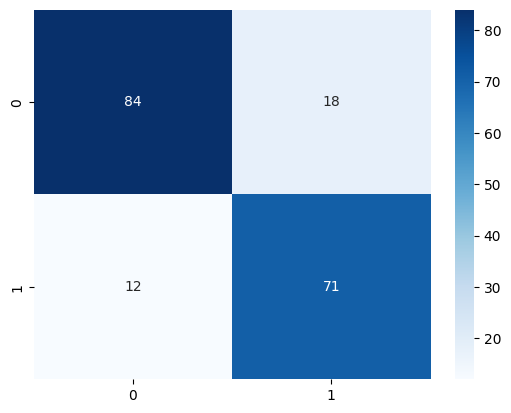

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model
y_pred = model.predict([X_test, X_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.show()


In [ ]:
# Evaluate model accuracy
test_loss, test_accuracy = model.evaluate([X_test, X_test], y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.8691 - loss: 0.3691
Test Loss: 0.5154
Test Accuracy: 0.8378


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


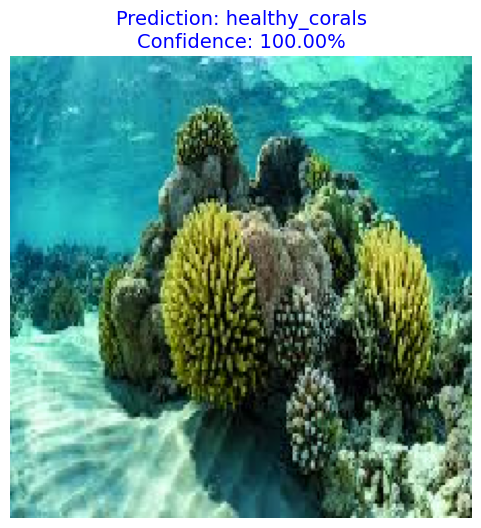

Predicted Class: healthy_corals (100.00%)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os

# Prediction function
def predict_and_display_image(image_path, model, classes):
    """
    Predict the class of a single image using the hybrid model and display it.

    Args:
        image_path (str): Path to the image file.
        model (Model): Trained hybrid model.
        classes (list): List of class names.

    Returns:
        None: Displays the image and prints the prediction result.
    """
    # Load and preprocess the image
    image = load_img(image_path, target_size=IMG_SIZE)  # Resize to (224, 224)
    image_array = img_to_array(image) / 255.0  # Normalize to [0, 1]
    image_batch = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict([image_batch, image_batch])
    predicted_class = classes[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=14, color="blue")
    plt.show()

    # Print the result
    print(f"Predicted Class: {predicted_class} ({confidence:.2f}%)")

# Define class names (same order as labels during training)
class_names = os.listdir(data_path)  # Assumes dataset folder names are class names

# Example usage
image_path = "/content/hl1.jfif"  # Replace with the path to your test image
predict_and_display_image(image_path, model, class_names)


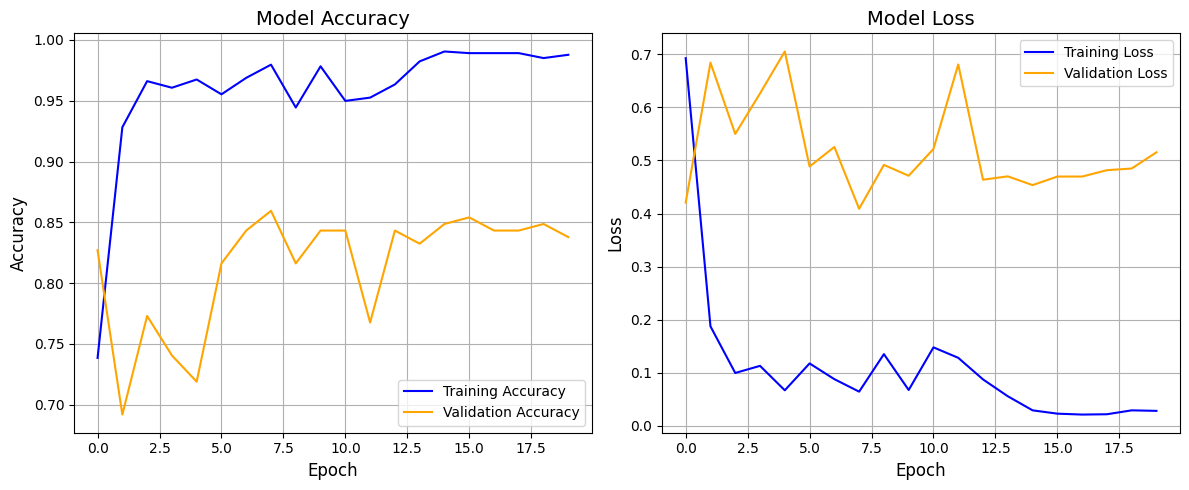

In [ ]:
# Assuming history is the training history object returned by model.fit()
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


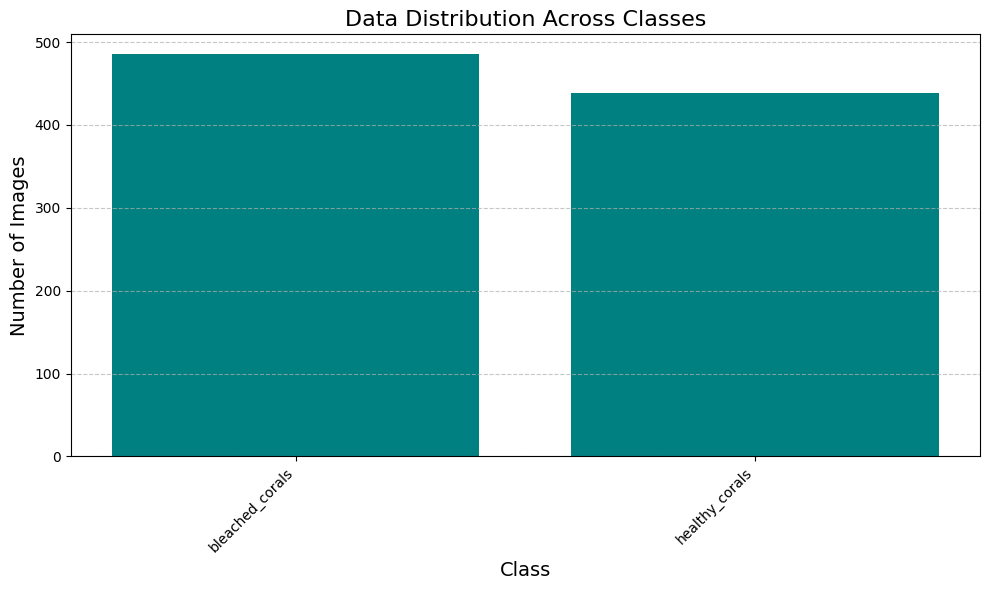

In [ ]:
import os
import matplotlib.pyplot as plt

# Data distribution visualization
class_counts = [len(os.listdir(os.path.join(data_path, class_name))) for class_name in class_names]

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='teal')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Data Distribution Across Classes', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
model.save("updatecnn.h5")
